## GPy crash course

In this tutorial I will run through a few basic features of GPy.

In [1]:
import GPy, numpy as np
from matplotlib import pyplot as plt
np.random.seed(1)
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
#import matplotlib;matplotlib.rcParams['figure.figsize'] = (8,5)

## Basic GP model
### 1D model

GPy handles the parameters of the parameter based models on the basis of the parameterized framework built in itself. The framework allows to use parameters in an intelligent and intuative way. 

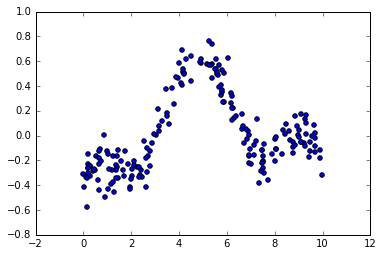

In [2]:
X = np.random.uniform(0, 10, (200, 1))
f = np.sin(.3*X) + .3*np.cos(1.3*X)
f -= f.mean()
Y = f+np.random.normal(0, .1, f.shape)
plt.scatter(X, Y)

A simple GP regression model with an RBF kernel can be constructed in the following way.

In [3]:
m = GPy.models.GPRegression(X, Y)

Details of the model can be shown in a ipython notebook with pretty printing in the following way

In [4]:
m

GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,


Or on the commandline in the following way

In [5]:
print(m)


Name : GP regression
Objective : 198.414142406
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |  value  |  constraints  |  priors
  rbf.variance             |    1.0  |      +ve      |        
  rbf.lengthscale          |    1.0  |      +ve      |        
  Gaussian_noise.variance  |    1.0  |      +ve      |        


Notice that there are a number of parameters of the model. Each one is a object itself, can be accessed seperately, in two different ways. Directly or via a regular expression

In [6]:
m.rbf.lengthscale

index,GP_regression.rbf.lengthscale,constraints,priors
[0],1.00000000,+ve,


In [7]:
m['.*lengthscale']

index,GP_regression.rbf.lengthscale,constraints,priors
[0],1.00000000,+ve,


We can plot the current model, with its default parameters in the following way.

 /Users/alansaul/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1718: UserWarning:This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.


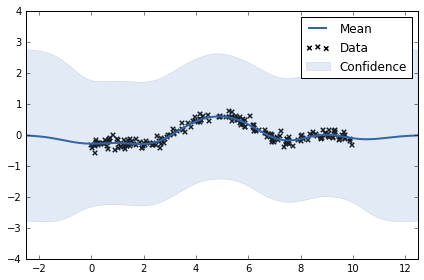

In [8]:
_ = m.plot()

Of course the default parameter values are not the optimal settings, as such we need to optimize them.

Note that all of the parameters of the model are restricted to be positive, as such we have a positive constraint on each of them (indicated by +ve). This is done by allowing the optimizer to optimize the parameters in the real space, but a transformation of $\log(\exp(theta) + 1)$ if performed before the parameter is given back to the model, gradients are transformed appropriately.

To find the optimal parameters we must optimize the model. A number of optimizers are available, such as 'scg', 'lbfgs', 'org-bfgs', 'fmin_tnc', as well as stochastic optimizers if a dependency on a package 'climin' is satisfied, such as 'adadelta' and 'rprop'.

In [9]:
m.optimize(messages=1, ipython_notebook=True)  # Messages indicates you wish to see the progress of the optimizer, needs ipywidgets to be installed
m

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


GP_regression.,value,constraints,priors
rbf.variance,0.130864941346,+ve,
rbf.lengthscale,1.36805842166,+ve,
Gaussian_noise.variance,0.010323494102,+ve,


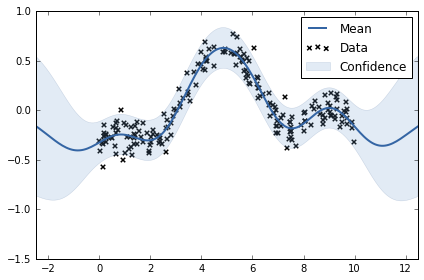

In [10]:
_ = m.plot()

Of course you may need to change the parameter settings such that the optimizer starts in a more sensible location. You can access the parameters with standard dot notation

In [11]:
m.rbf.lengthscale[:] = 0.1
m

GP_regression.,value,constraints,priors
rbf.variance,0.130864941346,+ve,
rbf.lengthscale,0.1,+ve,
Gaussian_noise.variance,0.010323494102,+ve,


Or you can set several parameters of an object at once, i.e if we wish to change both the lengthscale and the variance.

In [12]:
m.rbf[:] = 0.3
m

GP_regression.,value,constraints,priors
rbf.variance,0.3,+ve,
rbf.lengthscale,0.3,+ve,
Gaussian_noise.variance,0.010323494102,+ve,


We can also make additional constraints on the parameters. We may wish to fix some parameters, and fix the range of others.

In [13]:
m.Gaussian_noise[:] = 0.01
m.Gaussian_noise.fix()
m.rbf.lengthscale.constrain_bounded(0.1, 0.5)
m.rbf.variance[:] = 1.0
m

GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,0.3,"0.1,0.5",
Gaussian_noise.variance,0.01,+ve fixed,


Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


GP_regression.,value,constraints,priors
rbf.variance,0.051783879034,+ve,
rbf.lengthscale,0.499999991553,"0.1,0.5",
Gaussian_noise.variance,0.01,+ve fixed,


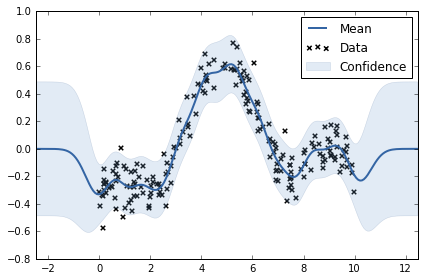

In [14]:
m.optimize(messages=1, ipython_notebook=True)  # Messages indicates you wish to see the progress of the optimizer
_ = m.plot()
m

Here we can see that the optimizer was not able to go above the bounds.

Instead of constraints you may wish to set a prior. In this case we will have a constraint where we need to consider the prior of the hyperparameter during optimization. HMC is available in GPy which allows hyperparameter integration, but here we will show a simple MAP solution.

 /Users/alansaul/Work/Code/GPy/GPy/core/parameterization/priors.py:301: RuntimeWarning:divide by zero encountered in log


GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,1.0,+ve,"Ga(3.2, 2.1)"
Gaussian_noise.variance,1.0,+ve,


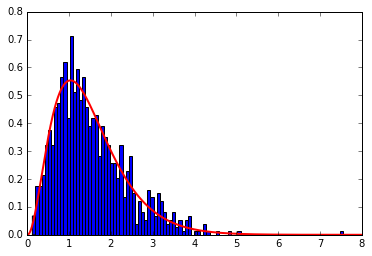

In [15]:
# Reset model
m.unconstrain()
m[:] = 1.0
m.constrain_positive()

# Make a gamma prior and set it as the prior for the lengthscale
gamma_prior = GPy.priors.Gamma.from_EV(1.5, 0.7)
gamma_prior.plot()
m.rbf.lengthscale.set_prior(gamma_prior)
m

GP_regression.,value,constraints,priors
rbf.variance,0.12881177115,+ve,
rbf.lengthscale,1.36155433892,+ve,"Ga(3.2, 2.1)"
Gaussian_noise.variance,0.0103243560503,+ve,


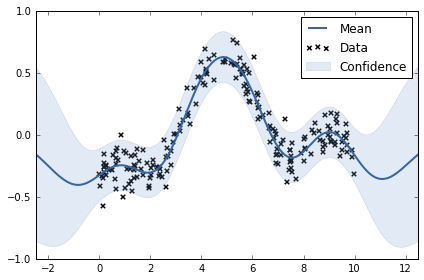

In [16]:
m.optimize()  # Messages indicates you wish to see the progress of the optimizer
_ = m.plot()
m

### Core GP model

A GPRegression model is a wrapper around a more flexible 'GP' model that expects input $X$, output $Y$, both of which must be 2d numpy arrays. It also expects you to provide your own likelihood, your own kernel and your own inference method. We will look at alternative models shortly but for now we will show what the wrapper is doing

gp.,value,constraints,priors
rbf.variance,0.130864941346,+ve,
rbf.lengthscale,1.36805842166,+ve,
Gaussian_noise.variance,0.010323494102,+ve,


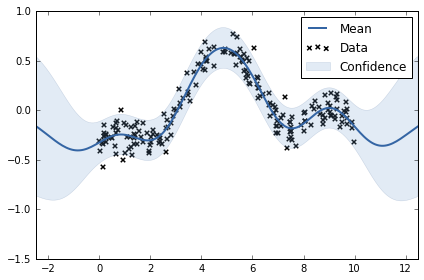

In [17]:
rbf_kern = GPy.kern.RBF(input_dim=1, lengthscale=1.0, variance=1.0)
gauss = GPy.likelihoods.Gaussian(variance=1.0)
exact = GPy.inference.latent_function_inference.ExactGaussianInference()
m1 = GPy.core.GP(X=X, Y=Y, kernel=rbf_kern, likelihood=gauss, inference_method=exact)
m1.optimize()
_ = m1.plot()
m1

### 2D model

Similarly for a GP over two dimensions very little needs to be done

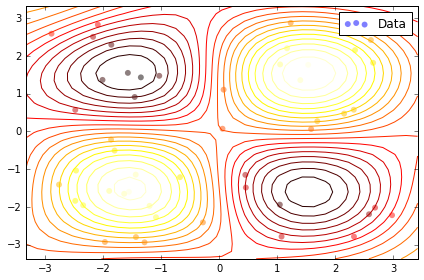

In [18]:
# sample inputs and outputs from 2d model
X2 = np.random.uniform(-3.,3.,(50,2))
Y2 = np.sin(X2[:,0:1]) * np.sin(X2[:,1:2]) + np.random.randn(50,1)*0.05

# define kernel, notice the number of input dimensions is now 2
ker = GPy.kern.RBF(input_dim=2, ARD=True)

# create simple GP model
m2 = GPy.models.GPRegression(X2,Y2,ker)
m2.optimize()
_ = m2.plot()

## Kernels

We will now dig into the details of what each component does and is capable of, starting with the kernel.

Kernel construction is modular. Kernels can be created seperately and then easily combined with simple operations such as addition, and multiplication, including over difference spaces. Lets explore

In [19]:
d = 1          # input dimension
var = 1.       # variance
theta = 0.2    # lengthscale
k = GPy.kern.RBF(d, variance=var, lengthscale=theta)

A summary of the kernel can be obtained using the command print k, or k in the notebook.

In [20]:
k

rbf.,value,constraints,priors
variance,1.0,+ve,
lengthscale,0.2,+ve,


In [21]:
print(k)

  rbf.         |  value  |  constraints  |  priors
  variance     |    1.0  |      +ve      |        
  lengthscale  |    0.2  |      +ve      |        


It is also possible to plot the kernel as a function of one of its inputs (whilst fixing the other) with k.plot().

Note: if you need help with a command in ipython notebook, then you can get it at any time by typing a question mark after the command, e.g. k.plot?

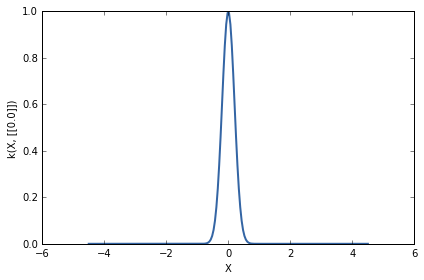

In [22]:
k.plot()

Simiarly to the model its parameters can be modified

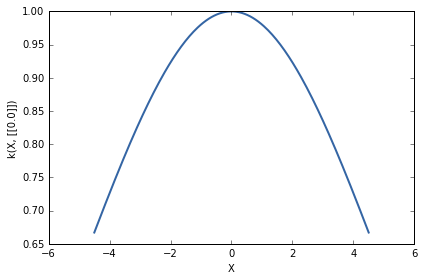

In [23]:
k.lengthscale=5.0
k.plot()

To compute the covariance function of the kernel on some set data, we just call k.K(X,X), or equivalently k.K(X)

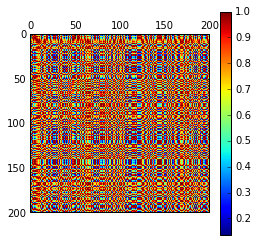

In [24]:
plt.matshow(k.K(X))
plt.colorbar()

### Combining kernels

In GPy you can easily combine covariance functions you have created using the sum and product operators, + and *. So, for example, if we wish to combine an exponentiated quadratic covariance with a Matern 5/2 then we can write

  sum.               |  value  |  constraints  |  priors
  rbf.variance       |    1.0  |      +ve      |        
  rbf.lengthscale    |    2.0  |      +ve      |        
  Mat32.variance     |    0.5  |      +ve      |        
  Mat32.lengthscale  |    0.2  |      +ve      |        


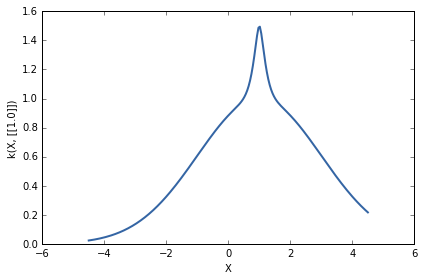

In [25]:
kern1 = GPy.kern.RBF(1, variance=1., lengthscale=2.)
kern2 = GPy.kern.Matern32(1, variance=0.5, lengthscale=0.2)
kern = kern1 + kern2
print kern

kern.plot()

Or if we wanted to multiply them we can write

  mul.               |  value  |  constraints  |  priors
  rbf.variance       |    1.0  |      +ve      |        
  rbf.lengthscale    |    2.0  |      +ve      |        
  Mat32.variance     |    0.5  |      +ve      |        
  Mat32.lengthscale  |    0.2  |      +ve      |        


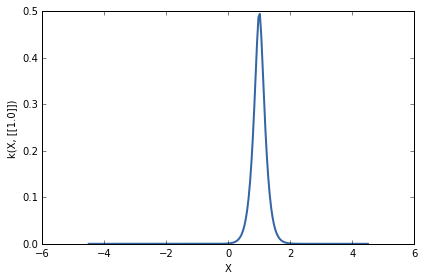

In [26]:
kern = kern1*kern2
print kern
kern.plot()

A range of kernels are implemented, and it is relatively straightforward to implement new ones.

* RBF (exponentiated quadratic, squared exponential, or any other name you wish to give it)
* Linear
* Bias
* Matern52
* Matern32
* Polynomial
* Brownian
* MLP
* Exponential
* Standard periodic

A full list can be found by doing ``GPy.kern.<tab>``

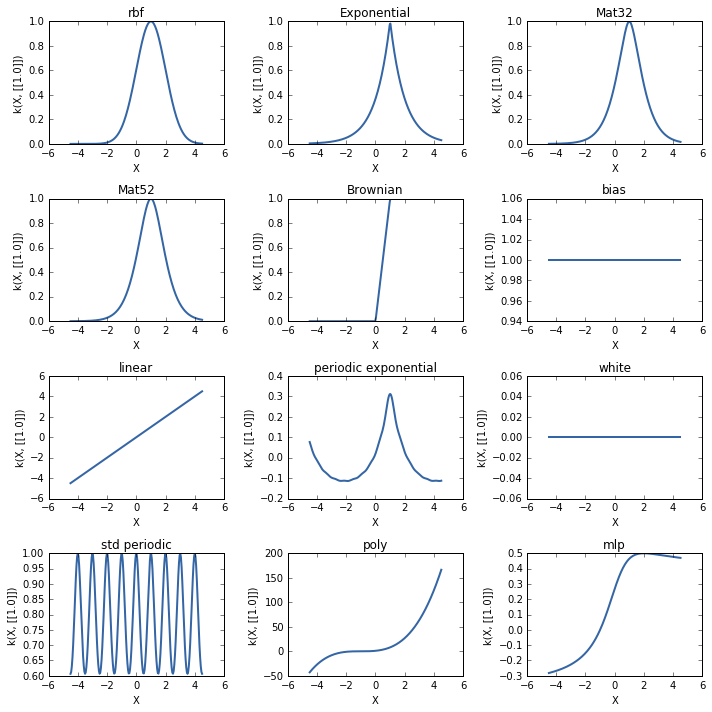

In [27]:
figure, axes = plt.subplots(4,3, figsize=(10,10), tight_layout=True)
kerns = [GPy.kern.RBF(1), GPy.kern.Exponential(1), GPy.kern.Matern32(1), 
         GPy.kern.Matern52(1), GPy.kern.Brownian(1),GPy.kern.Bias(1), 
         GPy.kern.Linear(1), GPy.kern.PeriodicExponential(1), GPy.kern.White(1), 
         GPy.kern.StdPeriodic(1), GPy.kern.Poly(1), GPy.kern.MLP(1)]

for k,a in zip(kerns, axes.flatten()):
    k.plot(ax=a, x=1)
    a.set_title(k.name.replace('_', ' '))

### Active dimensions

It may be that you only want one kernel to work one set of dimensions, and another kernel on another set. That is the two kernels work on different domains of the input. In GPy this capability is provided with active_dims argument to the kernel, which tell the kernel what to work on. Lets return back to a two dimensional example.

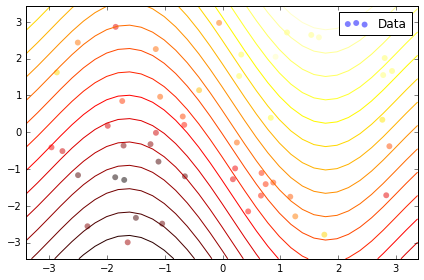

In [28]:
# sample inputs and outputs from 2d model
X2 = np.random.uniform(-3.,3.,(50,2))
Y2 = np.sin(X2[:,0:1]) + np.sin(X2[:,1:2]) + np.random.randn(50,1)*0.05

# define a sum kernel, where the first dimension is modelled with an RBF, and the second dimension is modelled with a linear kerel
ker = GPy.kern.RBF(input_dim=1, active_dims=[0]) + GPy.kern.Linear(input_dim=1, active_dims=[1])

# create simple GP model
m2 = GPy.models.GPRegression(X2,Y2,ker)
m2.optimize()
_ = m2.plot()

If we want to plot the marginal of the model where we fix one input to a certain value, we can use "fixed_inputs", the format for which is a list of tuples, where we specify the dimension, and the fixed value.

Here we fix the first dimension (the domain of the linear kernel) to 0.2

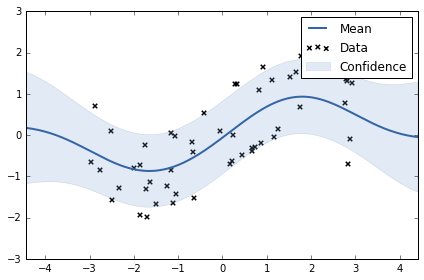

In [29]:
_ = m2.plot(fixed_inputs=[(1, 0.2)])

And then lets fix the zeroth dimension (domain of rbf) to 1.0

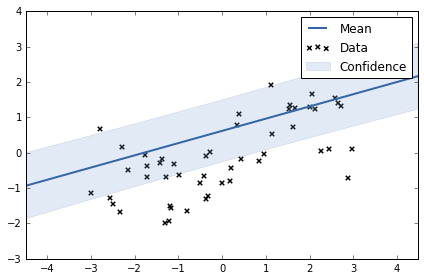

In [30]:
_ = m2.plot(fixed_inputs=[(0, 1.0)])

As we would expect, the data doesn't necessarily sit on the posterior distribution, as this is a projection of all the data onto one dimension.

## Non-Gaussian likelihoods

Considered the olympic marathon data that we use as a running example in many of our other notebooks. In 1904 we noted there was an outlier example. Today we'll see if we can deal with that outlier by considering a non-Gaussian likelihood. Noise sampled from a Student-t density is heavier tailed than that sampled from a Gaussian. However, it cannot be trivially assimilated into the Gaussian process. Below we use the Laplace approximation to incorporate this noise model.

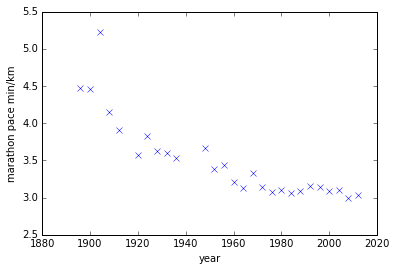

In [31]:
# Download the marathon data from yesterday and plot
GPy.util.datasets.authorize_download = lambda x: True # prevents requesting authorization for download.
data = GPy.util.datasets.olympic_marathon_men()
X = data['X']
Y = data['Y']

plt.plot(X, Y, 'bx')
plt.xlabel('year')
plt.ylabel('marathon pace min/km')

We might want to use a non-Gaussian likelihood here. This also means that our inference method can no longer be exact, and we have to use one of the approximate methods. Lets use a Student-T distribution that has heavy tails to allow for the outliers without drastically effecting the posterior mean of the GP.

In [32]:
GPy.likelihoods.StudentT?

### Laplace

gp.,value,constraints,priors
sum.rbf.variance,0.247079340096,+ve,
sum.rbf.lengthscale,18.0531700475,+ve,
sum.bias.variance,5.77057683482,+ve,
Student_T.t_scale2,0.00664234394947,+ve,
Student_T.deg_free,2.27411786114,+ve,


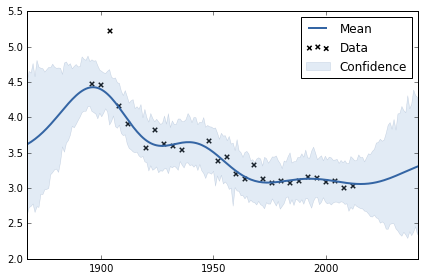

In [33]:
t_distribution = GPy.likelihoods.StudentT(deg_free=5.0, sigma2=2.0)
laplace = GPy.inference.latent_function_inference.Laplace()

kern = GPy.kern.RBF(1, lengthscale=5) + GPy.kern.Bias(1, variance=4.0)
m_stut = GPy.core.GP(X, Y, kernel=kern, inference_method=laplace, likelihood=t_distribution)

m_stut.optimize()
m_stut.plot(plot_density=False)

m_stut

### EP

If we instead wanted to perform classification, it might be that we want to use Expectation Propagation (EP). Currently EP only works on a couple of likelihoods, namely the Bernoulli likelihood

In [34]:
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import cPickle as pickle
import urllib

urllib.urlretrieve('http://staffwww.dcs.sheffield.ac.uk/people/M.Zwiessele/gpss/lab2/EastTimor.pickle', 'EastTimor2.pickle')

#Load the data
with open("./EastTimor2.pickle","rb") as f:
    Xeast,Yeast,polygons = pickle.load(f)

Now we will create a map of East Timor and, using GPy, plot the data on top of it. A classification model can be defined in a similar way to the laplace regression model, but now using GPy.inference.latent_function_inference.EP(). A wrapper for a classification model using EP is given by GPy.models.GPClassification()

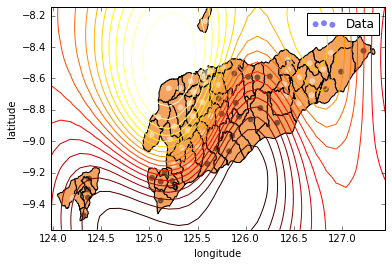

In [35]:
ep = GPy.inference.latent_function_inference.EP()
kern = GPy.kern.RBF(2, lengthscale=0.6, ARD=True)
bern = GPy.likelihoods.Bernoulli()
m_ep = GPy.core.GP(Xeast, Yeast, kernel=kern, inference_method=ep, likelihood=bern)


fig = plt.figure()
ax = fig.add_subplot(111)
for p in polygons:
    ax.add_collection(PatchCollection([Polygon(p)],facecolor="#F4A460"))
ax.set_xlim(124.,127.5)
ax.set_ylim(-9.6,-8.1)
ax.set_xlabel("longitude")
ax.set_ylabel("latitude")

m_ep.plot(ax=ax)

Now we optimize the hyper-parameters

In [36]:
m_ep.optimize()

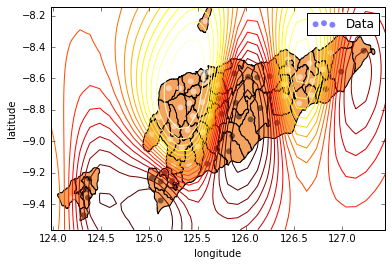

In [37]:
fig = plt.figure()
ax = fig.add_subplot(111)
for p in polygons:
    ax.add_collection(PatchCollection([Polygon(p)],facecolor="#F4A460"))
ax.set_xlim(124.,127.5)
ax.set_ylim(-9.6,-8.1)
ax.set_xlabel("longitude")
ax.set_ylabel("latitude")

m_ep.plot(ax=ax)


In [38]:
m_ep

gp.,value,constraints,priors
rbf.variance,2.23903462364,+ve,
rbf.lengthscale,"(2,)",+ve,
